In [11]:
%load_ext autoreload
%autoreload 2

import matplotlib
matplotlib.use('nbagg')
%matplotlib inline
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/usr/local/lib/python3.5/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Saving as a scenario

In [12]:
!ls ../mat/*

../mat/line_fresnelastique.npy ../mat/line_vague_solo.npy
../mat/line_vague_dense.npy    ../mat/master.npy


In [20]:
%%writefile ../scenario_line_master.py
#!/usr/bin/env python
# -*- coding: utf8 -*-

import elasticite as el
import numpy as np
import os

def master(e, filename):
    if e.structure: N_lame = e.N_lame-e.struct_N
    else: N_lame = e.N_lame

    def montage(z, z_in):
        print (z_in[0, 0], z[-1, 0], z_in[0, 0], z_in[-1, 0])
        z_in[:, 0] += z[-1, 0] + 1./e.desired_fps # increment the time on the new array
        print (z.shape, z_in.shape, z_in[0, 0], z_in[-1, 0])
        return np.vstack((z, z_in))

    
    matpath = 'mat/'
    z_s = {}
    for scenario in ['line_vague_dense', 'line_vague_solo', 'line_fresnelastique']:
        z_s[scenario] = np.load(os.path.join(matpath, scenario + '.npy'))
    
    ###########################################################################
    burnout_time = 4.
    z = np.zeros((1, N_lame+1)) # zero at zero
    z = np.vstack((z, np.hstack((np.array(burnout_time), np.zeros(N_lame) ))))
    for _ in range(36):
        ###########################################################################
        z = montage(z, z_s['line_vague_dense'])
        ###########################################################################
        z = montage(z, z_s['line_vague_solo'])
        ###########################################################################
        z = montage(z, z_s['line_fresnelastique'])
        ###########################################################################
        z = montage(z, z_s['line_vague_dense'])
    
    ###########################################################################
    # save the file
    np.save(filename, z)

        

if __name__ == "__main__":
    import sys
    if len(sys.argv)>1: mode = sys.argv[1]
    else: mode = 'both'
        
    filename='mat/master.npy'
    
    e = el.EdgeGrid(N_lame=25, grid_type='line', mode=mode,
                 verb=True, filename=filename)

    if mode == 'writer':
        master(e, filename)
    else:
        # running the code
        el.main(e)


Overwriting ../scenario_line_master.py


In [21]:
%cd ..
%run  scenario_line_master.py writer
%cd posts

/Users/laurentperrinet/pool/Dropbox/py-elasticite
0.0 4.0 0.0 19.8333333333
(2, 26) (596, 26) 4.03333333333 23.8666666667
0.0 23.8666666667 0.0 19.8666666667
(598, 26) (597, 26) 23.9 43.7666666667
0.0 43.7666666667 0.0 29.9333333333
(1195, 26) (899, 26) 43.8 73.7333333333
4.03333333333 73.7333333333 4.03333333333 23.8666666667
(2094, 26) (596, 26) 77.8 97.6333333333
77.8 97.6333333333 77.8 97.6333333333
(2690, 26) (596, 26) 175.466666667 195.3
23.9 195.3 23.9 43.7666666667
(3286, 26) (597, 26) 219.233333333 239.1
43.8 239.1 43.8 73.7333333333
(3883, 26) (899, 26) 282.933333333 312.866666667
175.466666667 312.866666667 175.466666667 195.3
(4782, 26) (596, 26) 488.366666667 508.2
488.366666667 508.2 488.366666667 508.2
(5378, 26) (596, 26) 996.6 1016.43333333
219.233333333 1016.43333333 219.233333333 239.1
(5974, 26) (597, 26) 1235.7 1255.56666667
282.933333333 1255.56666667 282.933333333 312.866666667
(6571, 26) (899, 26) 1538.53333333 1568.46666667
996.6 1568.46666667 996.6 1016.433333

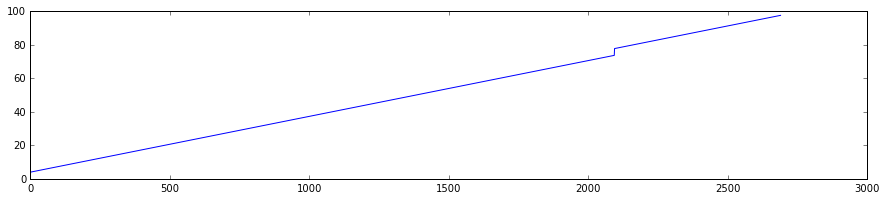

In [15]:
z = np.load('../mat/master.npy')
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0])

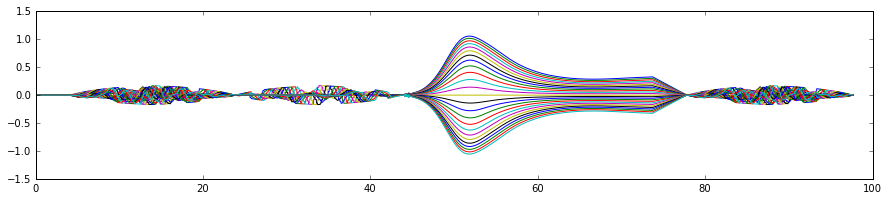

In [16]:
fig, ax = plt.subplots(figsize=(15, 3))
_ = ax.plot(z[:, 0], z[:, 1:])

## git


In [17]:
#! git add 2015-11-26*
!git s

 M ../mat/master.npy
 M "2015-10-14 \303\251lasticit\303\251, Fresnel.ipynb"
?? ../.gitignore_conflict-20151125-105937
?? "2015-11-02 \303\251lasticit\303\251 expansion en miroir - exploration param\303\250tres_conflict-20151125-105824.ipynb"
?? "2015-11-02 \303\251lasticit\303\251 expansion en miroir - principes_conflict-20151123-174335.ipynb"
?? "2015-11-17 \303\251lasticit\303\251 expansion en miroir - dynamique d'un point focal2.ipynb"
?? "2015-11-17 \303\251lasticit\303\251 expansion en miroir - dynamique d'un point focal_conflict-20151123-174338.ipynb"
?? ../scenario_line_fresnel_conflict-20151123-162407.py
?? ../src/elasticite_conflict-20151123-173759.py


In [18]:
!git commit -am' scenario master '

[master eaf6ddb]  scenario master
 2 files changed, 43 insertions(+), 4 deletions(-)


In [19]:
! git push

Counting objects: 21, done.
Delta compression using up to 4 threads.
Compressing objects: 100% (21/21), done.
Writing objects: 100% (21/21), 197.75 KiB | 0 bytes/s, done.
Total 21 (delta 15), reused 0 (delta 0)
To git@git.framasoft.org:laurentperrinet/elasticte.git
   f5634ef..eaf6ddb  master -> master
